>**Google colab notebook regarding diploma thesis: <br>Application of deep learning methods regarding weather forecast**

> This notebook presents snippet of work we have done using Convolutional neural networks (CNN).

>At first we load and process the data, then we create and train CNN model. <br> We worked with various CNN models and hyperparameters, such as ResNet, VGG and Xception. <br>
In the end we present our success, or lack of it, with classification of cloud coverage using convolutional neural networks.

>**Note:**
>results presented at the moment might not be exactly same as presented in official diploma thesis due to random sampling of data from dataset and possible changes in hyperparameters 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Imports

In [0]:
from os import makedirs
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from sklearn.model_selection import train_test_split

from keras import backend as K
import keras
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras_applications.resnet import ResNet101
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3  import InceptionV3
from keras.applications.xception import Xception
#from keras.applications.resnet50 import GlobalAveragePooling2D
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dropout
from keras import Model
from keras.applications.imagenet_utils import preprocess_input

import tensorflow as tf

Using TensorFlow backend.


In [0]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib as plt

Create constatnts and paths for google drive

In [0]:
PATH = '/content/gdrive/My Drive/formatted_pics2_224_rgb/'
PATH_TO_CSV = '/content/gdrive/My Drive/synops/df_9to8.csv'
PATH_TO_CODE = '/content/gdrive/My Drive/synops/' #not used anymore?
NUM_CLASSES = 9

In [0]:
def print_sorted_dict(mydict):
  for key in sorted(mydict):
    print ("%s: %s" % (key, mydict[key]))

Load csv file containing synops with timestamps and names of valid images

In [0]:
loader_df = pd.read_csv(PATH_TO_CSV)

Load image data. <br>Preprocess them, create dataframe with preprocessed images.<br>
Loading is executed from PATH setted up a few cells above

In [0]:
pht_dic = dict()
l = len(os.listdir(PATH))
print(l)
ind = 0
for img in os.listdir(PATH):
  if ind % 10 == 0:
    print(ind)
  ind+=1
  im_name = PATH +'/'+ img
  img_read = cv.imread(im_name)
  img_read = np.array(img_read, dtype=np.float64)
  img_read = preprocess_input(img_read)
  pht_dic[img] = [img_read]
formatted_df = pd.DataFrame.from_dict(pht_dic, orient='index').reset_index()

Join images with synops.<br>
As stated above, dataframe with synops contains image names and dataframe with images has column with image names.<br> That is how we can join them.

In [0]:
df = pd.merge(loader_df[['name','synop']], formatted_df, left_on=['name'], right_on=['index'], how='inner')
df.drop(columns=['index'], inplace=True)
df.rename(columns={0:'hst'}, inplace=True)

Prepare datasets<br>
Split dataframe from previous cell for training, validation and testing.<br> Do one-hot-encoding for synops.<br> In these cell we only create functions to do so, they are executed in next cell. 

In [0]:
def split_dataset(d, perc_to_use, perc_to_train):
    '''
    params:
    perc_to_use : size of dataset to use overall
    perc_to_train : percentage from sample of size 'perc_to_use' to use as train and validation data
    '''
    init_sample = d.sample(frac=perc_to_use)
    sample = init_sample.sample(frac=perc_to_train)
    print(sample.columns)
    complement_s = init_sample[~init_sample.name.isin(sample.name)]
    train, test = np.split(sample, [int(0.6*len(sample))])
    return train, test, complement_s
  
def one_hot_encode( synop):
	  empty = np.array([0,]*NUM_CLASSES)
	  syn_int = int(synop)
	  encoded = empty.copy()
	  encoded[syn_int - 1] = 1
	  return encoded
  
def do_one_hot(df):
    df.synop = df.synop.apply(lambda x: one_hot_encode(x))
    return df

Execute datasets split<br>
User can specify how much data ha wants to use and percentage of data that will be used for training and validation. Rest will be used for testing.<br>
split_dataset("joind dataframe", percentage of data to use from all the data, percentage of data from previous argument to use as train+validation)

In [0]:
train, validate, test = split_dataset(df,0.9, 0.8)
train = do_one_hot(train)
validate = do_one_hot(validate)
test = do_one_hot(test)

Index([u'name', u'synop', u'hst'], dtype='object')


Create class for creating confusion matrices

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    #print(type(y_true))
    #print(y_true.shape)
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = range(0,9)#classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)


Class for plotting classification accuracy

In [0]:
from keras.models import model_from_json
from keras.utils import plot_model
from json import dump
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


class Save_model:

	def __init__(self):
		pass
	
	def save_keras(self, dir_name, model=None, history=None, save_model_plot=False):
		self.dir_name = 'logs/' + dir_name + datetime.now().strftime('%c')
		makedirs(self.dir_name)
		if model:
			model_json = model.to_json()
			with open("model.json", "w") as json_file:
				json_file.write(model_json)
			# serialize weights to HDF5
			model.save_weights("{}/model.h5".format(self.dir_name))
			print("Saved model to disk")
			
		if history:
			self.plot_model_scores(history)
			with open('{}/history.json'.format(self.dir_name), 'w') as f:
				dump(history.history, f)
				
		if save_model_plot and model:
			plot_model(model, to_file='{}/model.png'.format(self.dir_name))
			
	def plot_model_scores(self, history):
		# Plot training & validation accuracy values
		plt.plot(history.history['acc'])
		plt.plot(history.history['val_acc'])
		plt.grid()
		plt.title('Model accuracy')
		plt.ylabel('Accuracy')
		plt.xlabel('Epoch')
		plt.legend(['Train', 'Test'], loc='upper left')
		plt.savefig('{}/acc.png'.format(self.dir_name))
		
		plt.figure()
		# Plot training & validation loss values
		plt.plot(history.history['loss'])
		plt.plot(history.history['val_loss'])
		plt.grid()
		plt.title('Model loss')
		plt.ylabel('Loss')
		plt.xlabel('Epoch')
		plt.legend(['Train', 'Test'], loc='upper left')
		plt.savefig('{}/loss.png'.format(self.dir_name))
		
		plt.figure()
		# categ acc
		plt.plot(history.history['categorical_accuracy']) 
		plt.plot(history.history['val_categorical_accuracy'])
		plt.grid()
		plt.title('categorical acc')
		plt.ylabel('categorical_acc')
		plt.xlabel('Epoch')
		plt.legend(['Train', 'Test'], loc='upper left')
		plt.savefig('{}/cat_acc.png'.format(self.dir_name))
		
		plt.figure()
		# custom metric same as loss at this moment
		plt.plot(history.history['custom_metric'])
		plt.plot(history.history['val_custom_metric'])
		plt.grid()
		plt.title('custom metric')
		plt.ylabel('custom_metric')
		plt.xlabel('Epoch')
		plt.legend(['Train', 'Test'], loc='upper left')
		plt.savefig('{}/custom_metric.png'.format(self.dir_name))
		
		plt.figure()
		# custom metric same as loss at this moment
		plt.plot(history.history['one_class_acc'])
		plt.plot(history.history['val_one_class_acc'])
		plt.grid()
		plt.title('one class acc')
		plt.ylabel('one class acc')
		plt.xlabel('Epoch')
		plt.legend(['Train', 'Test'], loc='upper left')
		plt.savefig('{}/one_class_acc.png'.format(self.dir_name))
    
def plot_error_hist( d, squared=False):
    plt.figure()
    plt.grid()
    if squared:
      plt.title('Histogram for squared error size')
      plt.xlabel('Size of squared error')
    else:
      plt.title('Histogram for error size')
      plt.xlabel('Size of error')
    plt.ylabel('Number of given errors')
    
    plt.bar(d.keys(), d.values())

Create class for Keras custom metric and custom loss function

In [0]:
from keras import backend as K
import tensorflow as tf

class Keras_metrics:
	
  def __init__(self):
    pass

  def loss(self, yt, yp, metric=False):
    '''
    metric: (1 - actual_difference_between_synops), such function raises as difference between synops lowers
    '''
    yt_ind = K.argmax(yt)
    yp_ind = K.argmax(yp)
    if metric:
      return 1 - K.square(yp-yt)   
    return K.square(yp - yt)
	

  def single_class_accuracy(self, y_true, y_pred):
    '''
    we test only one class now
    '''
    INTERESTING_CLASS_ID = 4
    # https://stackoverflow.com/questions/41458859/keras-custom-metric-for-single-class-accuracy
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    # Replace class_id_preds with class_id_true for recall here
    accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

Class for creating and handling models 

In [0]:
class T_keras():
	
  def __init__(self, train, validate):
    '''
    input shape: size of photos used,
    train & validate: products of split_dataset() function
    we need to reshape data for usage in Keras models
    '''
    self.input_shape = (224,224,3)
    self.custom_metric_obj = Keras_metrics()
    self.save_model = Save_model()
    self.train_reshape = np.array([x for x in train.hst.values]) 
    self.validate_reshape = np.array([x for x in  validate.hst.values]) 
    self.train_synp =  np.array([x for x in train.synop.values]) 
    self.validate_synp =  np.array([x for x in  validate.synop.values])
    self.test_reshape = np.array([x for x in test.hst.values])
    self.test_synp =  np.array([x for x in test.synop.values]) 
    
		
  def custom_loss(self, y_true, y_pred):
	  return self.custom_metric_obj.loss(y_true, y_pred)
	
  def custom_metric(self, y_true, y_pred):
	  return self.custom_metric_obj.loss(y_true, y_pred, metric=True)
	
  def one_class_acc(self, y_true, y_pred):
	  return self.custom_metric_obj.single_class_accuracy(y_true, y_pred)
  
  def test_error(self, y_true, y_pred): #not one hot encoded
    data_len = y_true.shape[0]
    err = 0
    err_sq = 0
    err_dict = dict()
    err_dict_sq = dict()
    for i in range(0,NUM_CLASSES):
      err_dict[i] = 0
      err_dict_sq[i**2] = 0
    for i in range(0,data_len):
      err += abs(y_true[i] - y_pred[i])
      err_dict[abs(y_true[i] - y_pred[i])]+=1
      err_sq += abs(y_true[i] - y_pred[i])**2
      err_dict_sq[abs(y_true[i] - y_pred[i])**2]+=1
    
    relative_err = err/data_len
    relative_err_sq = err_sq/data_len
    return (err_dict, err_dict_sq, relative_err, relative_err_sq)
    
  def trainable_setup(self, base_model):
	  # https://github.com/keras-team/keras/issues/9214
	  trainable_list = []
	  trainable1 = []
	  for layer in base_model.layers:
		  trainable1.append(layer.trainable)
	  #print(trainable1)
		
	  for layer in base_model.layers:
		  if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
				layer.trainable = True
				trainable_list.append(True)
				K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
				K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
		  else:
				layer.trainable = False
				trainable_list.append(False)
		#print(trainable_list)
	  c= 0
	  for i,j in zip(trainable1, trainable_list):
			c+=1
	  print('trainable changed on : ' + str(c))
	  return base_model
		
  def resnet_model(self, model, optimizer_name, epochs=10, complex_setup=False, weights='imagenet', dropout=True, save=False):
    dataset_len = self.train_reshape.shape[0] + self.validate_reshape.shape[0]
    print('running on: {}, with weights: {}'.format(dataset_len, weights))
    
    if model == 'VGG16':
      base_model = VGG16(input_shape=self.input_shape, weights=weights, include_top=False,backend=keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils) 
    if model == 'ResNet50':
      base_model = ResNet50(input_shape=self.input_shape, weights=weights, include_top=False,backend=keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils) 
    if model == 'Xception':
      base_model = Xception(input_shape=self.input_shape, weights=weights, include_top=False,backend=keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils) 
    if model == 'ResNet101':
      base_model = ResNet101(input_shape=self.input_shape, weights=weights, include_top=False,backend=keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)

    if complex_setup:
			base_model = self.trainable_setup(base_model)
			
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if dropout:
			x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs= base_model.inputs, outputs= predictions)
    model.compile(optimizer=optimizer_name, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy',self.custom_metric, self.one_class_acc])
    history_callback = model.fit(self.train_reshape, self.train_synp, validation_data=(self.validate_reshape, self.validate_synp), epochs=epochs)
    self.save_model.save_keras('test_epochs{}_size{}_weights-{}'.format(str(epochs), str(self.train_reshape.shape[0]), weights), None, history_callback, save_model_plot=True)
    return model, history_callback
  
  def test_model(self, model):
    test_pred = model.predict(self.test_reshape)
    return test_pred
  
  def stats(self, test_pred, history_callback):
    train_pred = model.predict(self.train_reshape)
    #print('going to plot')
    
    print(history_callback.history)
    
    test_pred =np.array(np.argmax(test_pred, axis= 1))
    test_synp =np.array(np.argmax(self.test_synp, axis= 1))
    train_pred =np.array(np.argmax(train_pred, axis= 1))
    train_synp =np.array(np.argmax(self.train_synp, axis= 1))
    
    error_dict, error_dict_sq, relative_err, relative_err_sq = self.test_error(test_synp, test_pred)
    
    plot_confusion_matrix(test_synp, test_pred, classes=range(0,9), normalize=True,
                      title='Normalized confusion matrix for validation data')
    plot_confusion_matrix(train_synp, train_pred, classes=range(0,9), normalize=True,
                     title='Normalized confusion matrix for train data')
    plot_error_hist(error_dict)
    plot_error_hist(error_dict_sq)
    plt.show()
    return error_dict, error_dict_sq, relative_err, relative_err_sq

running on: 1954, with weights: imagenet
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1172 samples, validate on 782 samples
Epoch 1/40
1172/1172 [==============================] - 41s 35ms/step - loss: 2.0252 - categorical_accuracy: 0.2756 - acc: 0.2756 - custom_metric: 0.9065 - one_class_acc: 0.0523 - val_loss: 1.7823 - val_categorical_accuracy: 0.3977 - val_acc: 0.3977 - val_custom_metric: 0.9150 - val_one_class_acc: 0.0000e+00
Epoch 2/40
1172/1172 [==============================] - 29s 25ms/step - loss: 1.6438 - categorical_accuracy: 0.4326 - acc: 0.4326 - custom_metric: 0.9206 - one_class_acc: 0.0546 - val_loss: 1.5644 - val_categorical_accuracy: 0.4450 - val_acc: 0.4450 - val_custom_metric: 0.9234 - val_one_class_acc: 0.0716
Epoch 3/40
1172/1172 [==============================] - 30s 2

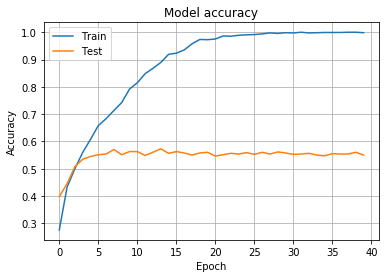

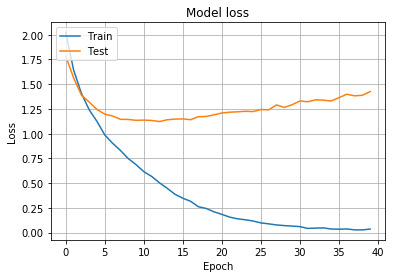

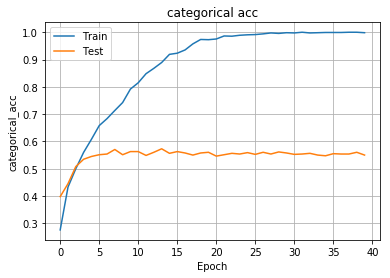

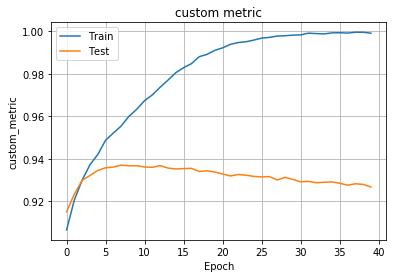

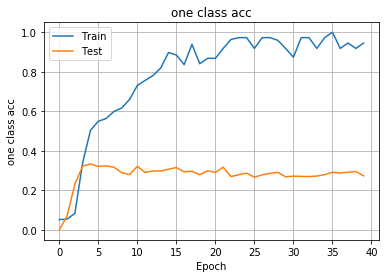

In [0]:
t_alg_xception_sgd = T_keras(train, validate)
model, history = t_alg_xception_sgd.resnet_model('Xception','sgd', epochs=40, complex_setup=False, weights='imagenet', save=True)


In [0]:
test_predictions = t_alg_xception_sgd.test_model(model)

**Confusion matrices and error size frequency** <br>

>


Here we present confusion matrices for training and validation data <br>
Next bar graphs represent frequency of error of given size on test size.<br>
First bar graphs present absolut size of error, second one shows squared error size <br>

{'val_categorical_accuracy': [0.3976982098711116, 0.4450127879524475, 0.5076726344235413, 0.5345268544486111, 0.5447570334767442, 0.5511508953693273, 0.5537084399739189, 0.5703324809708559, 0.5511508952168858, 0.5626598466235353, 0.5626598465473146, 0.5485933504598525, 0.5601023017902813, 0.5728900256516684, 0.556265984807173, 0.5626598466235353, 0.5575447571094688, 0.5498721229145899, 0.5575447571094688, 0.5601023017902813, 0.5460358057028193, 0.5511508952168858, 0.5562659847309522, 0.5537084398976982, 0.5588235294879855, 0.5524296675191815, 0.5601023022476059, 0.5537084399739189, 0.5613810746261226, 0.5575447570332481, 0.5524296675191815, 0.5537084398976982, 0.5562659846547314, 0.5498721227621484, 0.5473145780813359, 0.5549872122762148, 0.5537084398976982, 0.5537084398976982, 0.5601023022476059, 0.5498721229145899], 'loss': [2.025157076506891, 1.6438397519010732, 1.4075719671444682, 1.240993227568096, 1.1236390217172407, 0.9865532938530828, 0.9033218618139065, 0.8305162463985613, 0.7

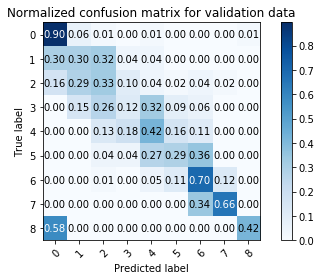

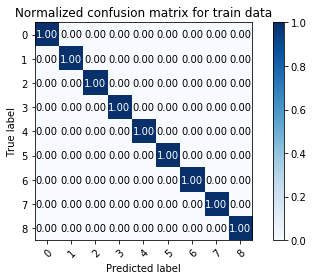

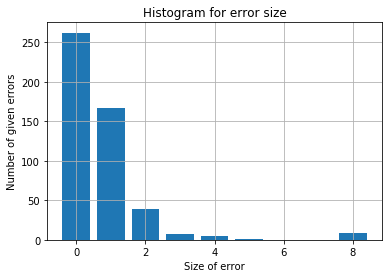

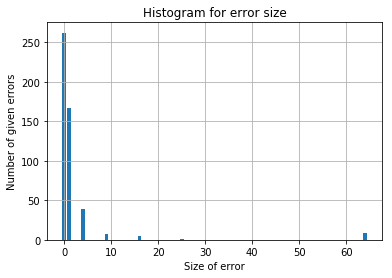

In [0]:
error_dict, error_dict_sq, synop_avg_error, synop_avg_error_sq = t_alg_xception_sgd.stats(test_predictions, history)

**Results of run**

Dictionary of error size frequency

In [0]:
print_sorted_dict(error_dict)

0: 262
1: 167
2: 39
3: 7
4: 5
5: 1
6: 0
7: 0
8: 8


Dictionary of error size frequency, where every error was squared

In [0]:
print_sorted_dict(error_dict_sq)

0: 262
1: 167
4: 39
9: 7
16: 5
25: 1
36: 0
49: 0
64: 8


Average error, "how far in absolute measurement was prediction by trained network from real synop "

In [0]:
synop_avg_error

0.7259713701431493

Average error computed as square of all errors.

In [0]:
synop_avg_error_sq

2.051124744376278

**A word about square error**

> During studying of literature, we found Ryo Onishi's article on similar topic.<br> Differences were they did not use pre-trained models, but trained one themselves, they also had slightly more data, and the data contained more elements from earth, such as buildings and water masses. They also classified images into 10 classes instead of 9.<br>As a result they present mean squared error of 2.49. Our mean square error was 2.05. <br> From that result we assume, that it is possible to get similar results with pretrained models on less time-consuming computations (Onishi's work used over 260 000 epochs). <br>
We understand that these results cannot be exactly compared due to difference in number of classes used and difference in data. However we think it shows advantages of using pre-trained models.

Article mentioned above:<br>
Onishi, Ryo & Sugiyama, Daisuke. (2017). <br>
Deep Convolutional Neural Network for Cloud Coverage Estimation from Snapshot Camera Images.<br>
SOLA. 13. 235-239. 10.2151/sola.2017-043. <br>